### Workbook -- FCNN

In this workbook, we will instantiate and train a Graph Attention Network, and compare its predictions to our old (photoz) method.

In [1]:
import numpy as np
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import time

# for aesthetics/plotting
sns.set_theme()
plt.style.use("seaborn-v0_8")

In [2]:
# Global variables

BATCH_SZ = 32
LR = 5e-4  # learning rate
NUM_HEADS = 5  # number of attention heads
NH = 128  # number of hidden dimensions
DECAY = 1e-5  # weight decay for L2 regularization
NE = 15  # number of epochs

In [3]:
# Load data
from preprocess import load

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag", zmax=2)

print("Data shape [input_size, num_features]:\t", data.shape)
print("Label size [input_size,]:\t\t", labels.shape,"\n")
print("Feature names:", features)

Data shape [input_size, num_features]:	 (51255, 7)
Label size [input_size,]:		 (51255,) 

Feature names: ['res' 'u_cmodel_mag' 'g_cmodel_mag' 'r_cmodel_mag' 'i_cmodel_mag'
 'z_cmodel_mag' 'Y_cmodel_mag']


In [4]:
# Reshape data into [input_size, num_nodes, num_features_per_node] (for graphs)

data = data[:,:,np.newaxis]

print("Data shape [input_size, num_nodes, num_features_per_node]:\t", data.shape)

Data shape [input_size, num_nodes, num_features_per_node]:	 (51255, 7, 1)


Next, we will prepare our graphs using KNN

In [5]:
from preprocess import prepare_graphs

# Check for CUDA, then default to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

graphs = prepare_graphs(data, labels, k=6, device=device)

/Users/jmduchar/anaconda3/envs/final_project/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Device: cpu


100%|██████████| 801/801 [00:02<00:00, 309.70it/s]


We can visualize the resulting graphs below:

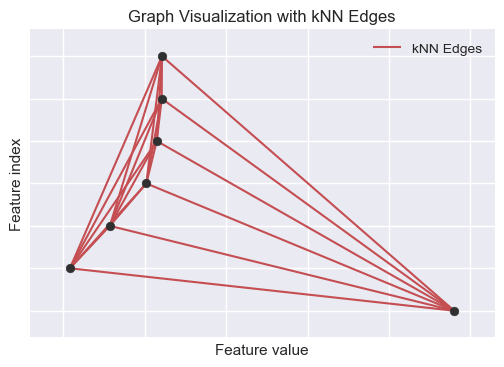

In [6]:
from visualize import visualize_graph

visualize_graph(graphs[42])

### Implementing Graph Attention Network

In [7]:
from model import GATRegression, run_model
from preprocess import split_graphs, time_elapsed

gat_model = GATRegression(num_features=1, hidden_dim=NH, num_heads=NUM_HEADS)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(gat_model.parameters(), lr=LR, weight_decay=DECAY)

# Data preparation
train_set, val_set, test_set = split_graphs(graphs, 0.7, 0.15)

train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SZ, shuffle=True)

loss_list = []
val_loss_list = []


t0 = time.time()
for epoch in range(1,NE+1):

    loss = run_model(gat_model, "gat", device, train_loader, criterion, optimizer=optimizer, train=True)
    loss_list.append(loss)

    # validation
    val_loss = run_model(gat_model, "gat", device, val_loader, criterion, train=False)
    val_loss_list.append(val_loss)

    if epoch%5 == 0:
        print(f"E {epoch:02d}\t Train loss: {loss:.3f}\t "\
            + f"Val loss: {val_loss:.3f}\t t elapsed: {time_elapsed(t0,time.time())} mins"
    )


E 05	 Train loss: 0.014	 Val loss: 0.014	 t elapsed: 1.48 mins
E 10	 Train loss: 0.014	 Val loss: 0.015	 t elapsed: 2.86 mins
E 15	 Train loss: 0.013	 Val loss: 0.014	 t elapsed: 4.32 mins
E 20	 Train loss: 0.013	 Val loss: 0.014	 t elapsed: 5.75 mins
E 25	 Train loss: 0.013	 Val loss: 0.014	 t elapsed: 7.29 mins


KeyboardInterrupt: 

In [8]:
# How does the model perform on unseen data?
test_loss = run_model(gat_model, "gat", device, test_loader, criterion, train=False)

print(f"Final test loss: {test_loss:.4f}")

Final test loss: 0.0144


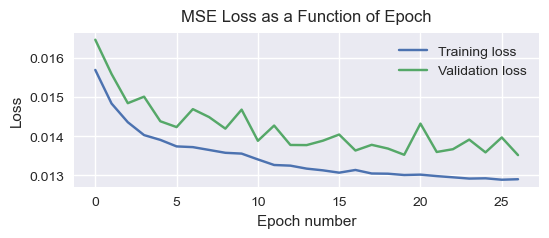

In [9]:
from visualize import plot_loss

plot_loss(loss_list, val_loss_list)

----------------- Linear Regression Parameters -----------------
Slope:					 0.6741156342612992
Intercept:				 0.061005678514810646
Coefficient of determination (R2):	 0.7587086833737977
p-value for null hypothesis:		 0.0
Standard error on the slope:		 0.004336000047645364


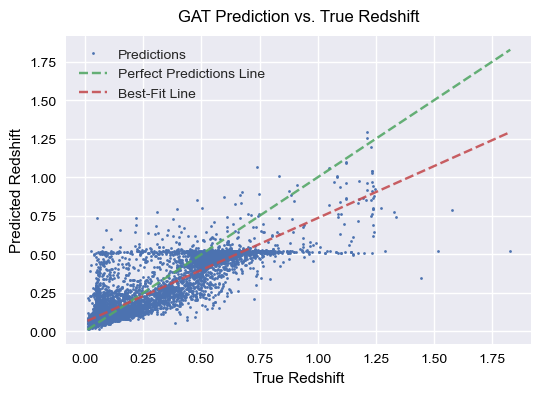

In [10]:
from model import get_predictions
from visualize import visualize_predictions

test_labels, test_preds = get_predictions(test_set, gat_model, device=device, model_type='gat')

visualize_predictions(test_labels, test_preds, "GAT", 
                      #savepath="./gat_preds.png", 
                      #transparent=True,
                      )

Now, let's compare this to the Old Method

In [ ]:
old_z, true_z, features = load("./data/specz_photoz.csv", mode="all", zmax=2)


In [ ]:
print(f"GAT's Mean-Squared Error on the test set: {test_loss:.4f}")

old_method_mse = mean_squared_error(true_z.flatten(), old_z.flatten())

print(f"Non-ML (photoz) Mean-Squared Error:", round(old_method_mse,4))

percent_diff = np.abs(test_loss-old_method_mse)/(0.5*(test_loss+old_method_mse))*100

print(f"Percent difference: {round(percent_diff,2)}%")

GAT's Mean-Squared Error on the test set: 0.0129
Non-ML (photoz) Mean-Squared Error: 0.0259
Percent difference: 66.76%
